In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, RobustScaler, TargetEncoder
HTML(
"""
<style>
    h1{
        font-size:20px;
        font-family:Helvetica;
        color:blue;
    }
  
    
</style>
"""
)


<h1>1 - IMPORTING TRAIN AND TEST DATA</h1>

In [52]:
df_train = pd.read_csv("./data/train.csv")
df_train.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,...,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,...,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,...,45,93,17.4,1,0.8,27,31,53,0,1
3,3,35,180,95,105.0,1.5,1.2,1,1,131,...,38,102,15.9,1,1.0,20,27,30,1,0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,...,44,93,15.4,1,0.8,19,13,17,0,1


(159256, 24)

In [56]:
df_test = pd.read_csv("./data/test.csv")
df_test.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,159256,40,165,70,84.0,1.2,1.2,1,1,130,...,186,49,115,14.2,1,0.9,19,25,32,0
1,159257,80,160,60,93.0,1.0,1.0,2,2,144,...,158,35,104,13.0,1,1.1,20,12,24,0
2,159258,60,170,70,86.5,0.6,0.7,1,1,117,...,173,39,88,15.4,1,1.4,38,60,36,0
3,159259,40,160,50,67.0,0.3,0.4,1,1,116,...,47,75,128,14.5,1,0.6,25,18,10,1
4,159260,40,170,75,89.4,1.0,0.9,1,1,132,...,100,39,123,16.5,1,1.0,30,39,27,1


In [57]:
df_test.shape

(106171, 23)

<ul>
    <li>
        Some columns have names with spaces
    </li>
    <li>
        This may cause some troubles later on, let's remove them
    </li>
</ul>

In [4]:
df_train.columns = [ col if' ' not in col else '_'.join(col.split(' ')).lower() for col in df_train.columns ]

In [6]:
target = 'smoking'

<h1>Let's check whether there is missing data or duplicated data in the dataset</h1>

In [7]:
df_train.isna().sum()

id                     0
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting_blood_sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
urine_protein          0
serum_creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental_caries          0
smoking                0
dtype: int64

In [8]:
df_train.duplicated().sum()

0

In [58]:
df_test.isna().sum()

id                     0
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
dtype: int64

In [60]:
df_test.duplicated().sum()

0

In [68]:
df_test.columns = [ col if' ' not in col else '_'.join(col.split(' ')).lower() for col in df_test.columns ]

<h1>There is no missing or duplicated data in both train and test sets</h1>
<hr>

<h1>2 - EDA</h1>

<h1>Correlation Matrix</h1>
<ul>
    <li>
        <code>height</code> and <code>hemoglobin</code> are the most correlated features with the target.
    </li>
    <li>
        <code>LDL</code> has high correlation with <code>cholesterol</code>. It's interesting that <code>HDL</code> has low correlation with <code>cholesterol</code>. A combination of <code>LDL</code>, <code>HDL</code> and <code>cholesterol</code> may become an interesting feature, it will be explored during feature engineering.
    </li>
    <li>
        There also some features with moderate correlation with one another. PCA may be worth a try as well.
    </li>
</ul>
<hr>

<Axes: >

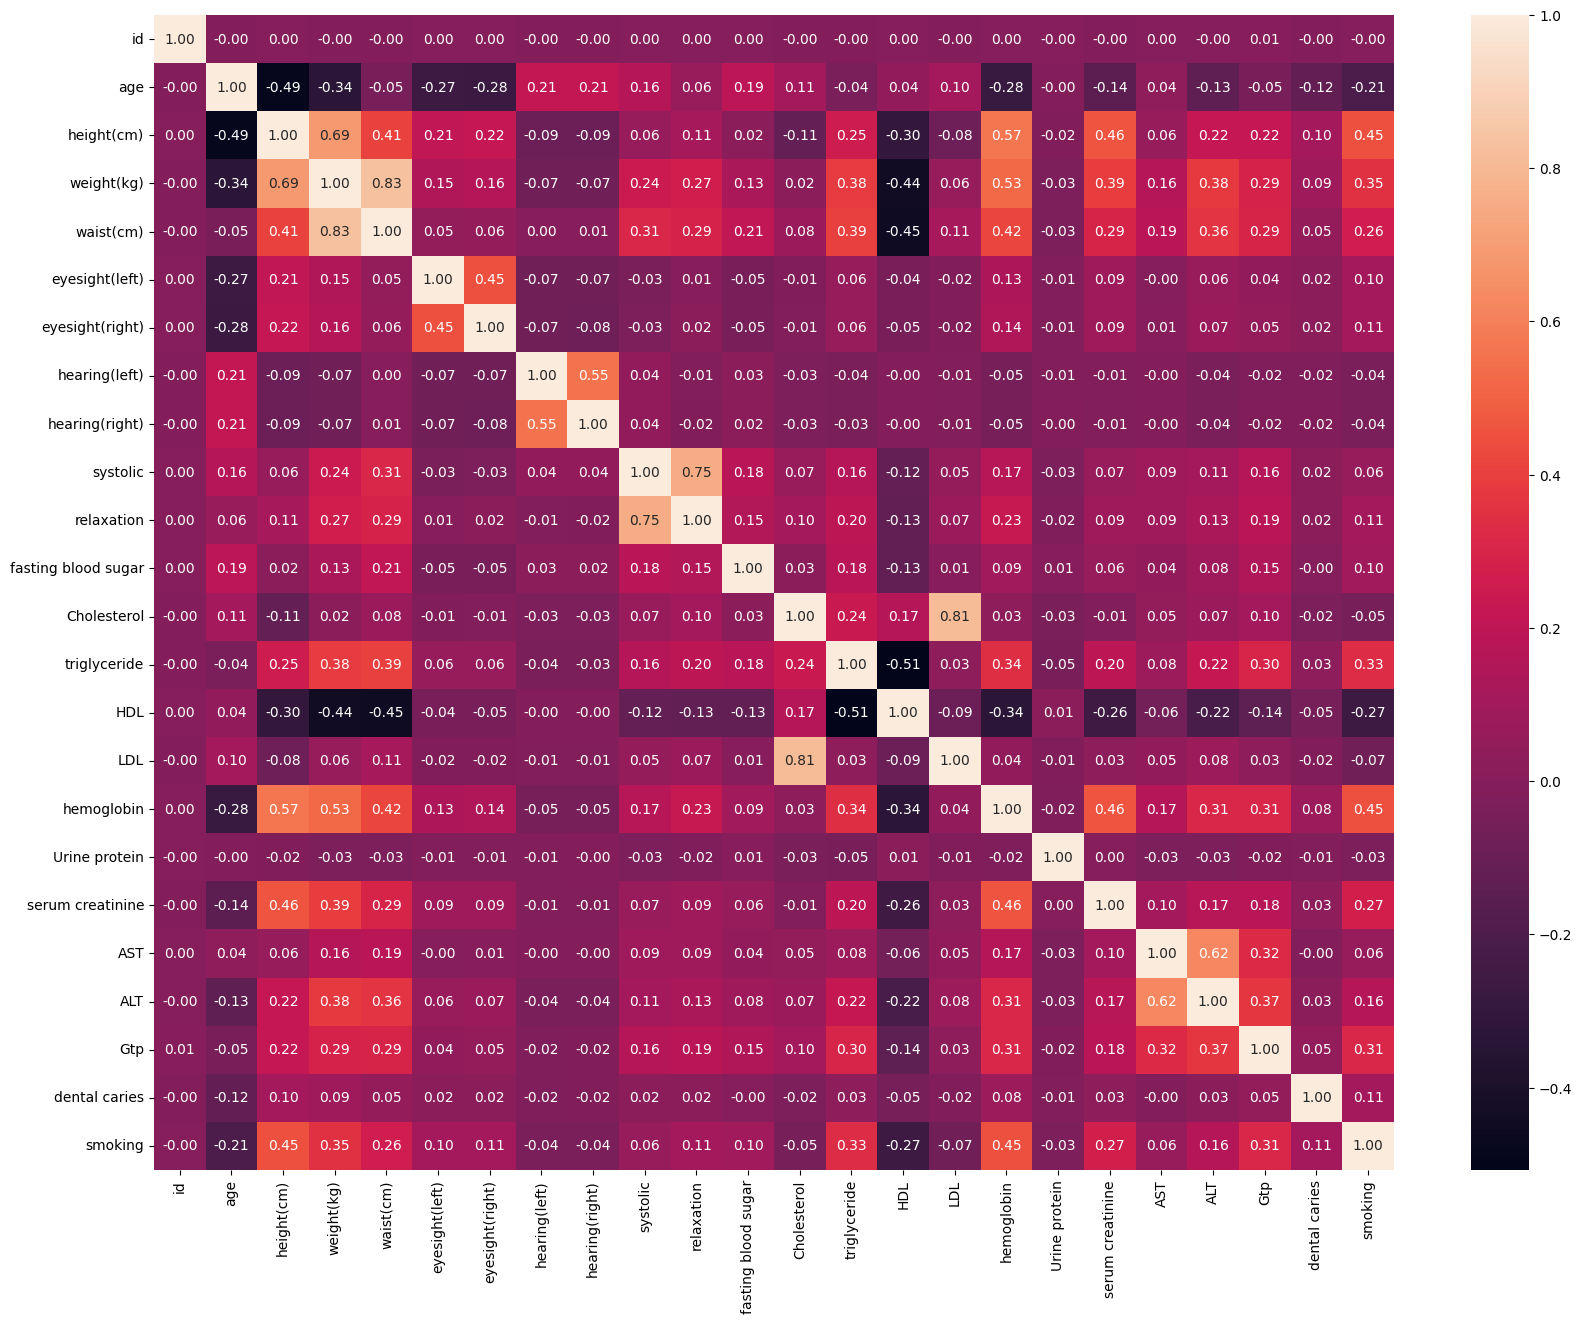

In [62]:
corr_map = df_train.corr()
plt.figure(figsize=(20,15))
sns.heatmap(data=corr_map,annot=True,fmt='.2f')

<h1>Checking uniqueness of the data</h1>
<ul>
    <li>
        Some features have a low number of possible values.
    </li>
    <li>
        <code>hearing(left)</code>, <code>hearing(right)</code> and <code>dental_caries</code> have only 2 values and are categoriacal features. Their values in the dataset are 1 and 2, perhaps it is useful to change them to 0 or 1.
    </li>
    <li>
        <code>urine_protein</code>, <code>height(cm)</code>, <code>eyesight(right)</code> and <code>eyesight(left)</code> have also a low number of unique values. Grouping them should reveal trends and more information about the target
    </li>
</ul>
<hr>

In [9]:
df_train.drop(columns=['id',target]).nunique().to_frame().rename(columns={0:'n_unique'})

,n_unique
age,18
height(cm),14
weight(kg),28
waist(cm),531
eyesight(left),20
eyesight(right),17
hearing(left),2
hearing(right),2
systolic,112
relaxation,75


In [64]:
cat_features = df_train.drop(columns=['id',target]).nunique().to_frame().rename(columns={0:'n_unique'}).query("n_unique<=2").index.tolist()

In [65]:
num_features = list(set(df_train.drop(columns=['id',target]).columns) - set(cat_features))
num_features

['HDL',
 'LDL',
 'ALT',
 'triglyceride',
 'fasting blood sugar',
 'waist(cm)',
 'eyesight(right)',
 'relaxation',
 'Gtp',
 'systolic',
 'Cholesterol',
 'eyesight(left)',
 'age',
 'height(cm)',
 'serum creatinine',
 'AST',
 'Urine protein',
 'weight(kg)',
 'hemoglobin']

In [66]:
# concatenate numerical and categorial features
features = num_features + cat_features

In [67]:
if len(num_features) + len(cat_features) + 2 != df_train.shape[1]:
    raise ValueError("dimensions do not match")

In [45]:
def plot_train_test_distribution():
    n_features = len(cat_features) + len(num_features)
    features = num_features + cat_features 
    df_train_plot = df_train[features].copy()
    df_train_plot['label'] = 'TRAIN'
    
    df_test_plot = df_test[features].copy()
    df_test_plot['label'] = 'TEST'
    
    df_plot = pd.concat([df_train_plot,df_test_plot],axis=0)
    
    plt.tight_layout(w_pad=3,h_pad=4)
    for idx,f in enumerate(features):
        if f in num_features:
            fig = plt.figure(figsize=(15,4))
            plt.subplot(121)
            sns.histplot(data=df_plot,x=f,hue='label',kde=True)
            
            plt.subplot(122)
            sns.boxplot(data=df_plot,x=f,orient='h',y='label')
            
        if f in cat_features:
            plt.figure(figsize=(15,4))
            sns.countplot(data=df_plot,x=f,hue='label')
        plt.show()

In [47]:
def plot_target_variables_interaction():
    n_features = len(cat_features) + len(num_features)
    features = num_features + cat_features 
    df_train_plot = df_train[features].copy()
    df_plot = df_train
    
    plt.tight_layout(w_pad=3,h_pad=4)
    for idx,f in enumerate(features):
        if f in num_features:
            fig = plt.figure(figsize=(15,4))
            plt.subplot(121)
            sns.histplot(data=df_plot,x=f,hue=target,kde=True)
            
            plt.subplot(122)
            sns.boxplot(data=df_plot,y=f,x=target)
            
        if f in cat_features:
            plt.figure(figsize=(15,4))
            sns.countplot(data=df_plot,x=f,hue=target)
        plt.show()
    plt.close()


<Axes: xlabel='smoking', ylabel='count'>

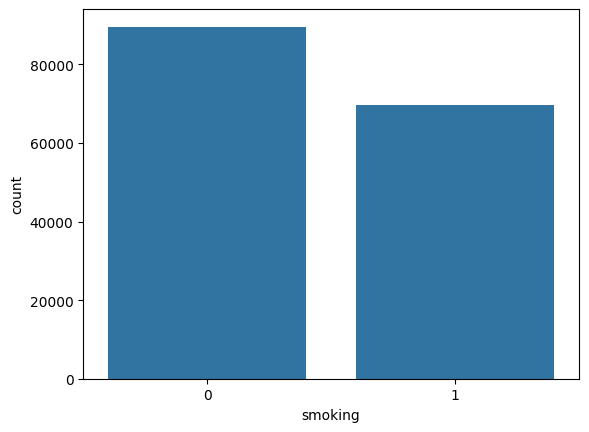

In [19]:
sns.countplot(data=df_train,x=target)

<Axes: xlabel='height(cm)', ylabel='smoking'>

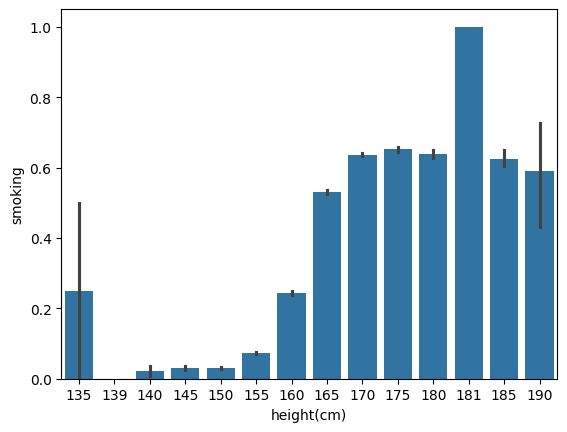

In [29]:
sns.barplot(data=df_train,x='height(cm)',y=target)

<Axes: xlabel='age', ylabel='smoking'>

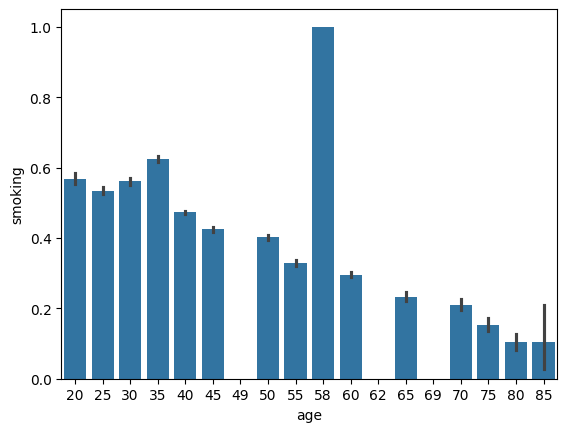

In [30]:
sns.barplot(data=df_train,x='age',y=target)

<Axes: xlabel='dental_caries', ylabel='smoking'>

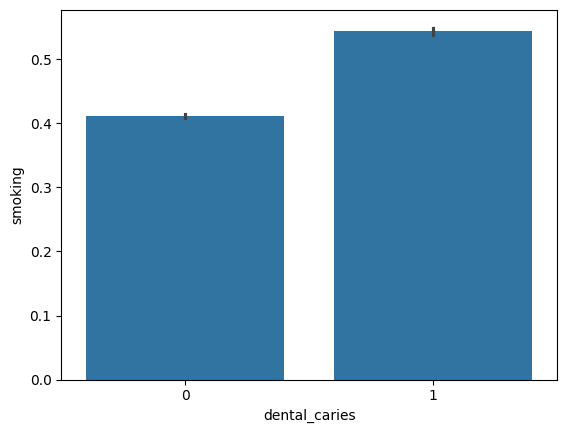

In [27]:
sns.barplot(data=df_train,x=cat_features[2],y=target)

<Figure size 640x480 with 0 Axes>

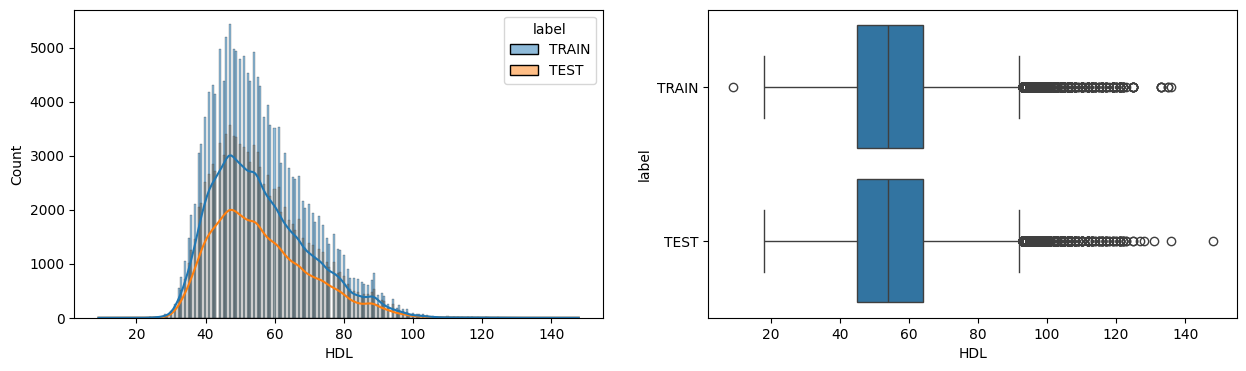

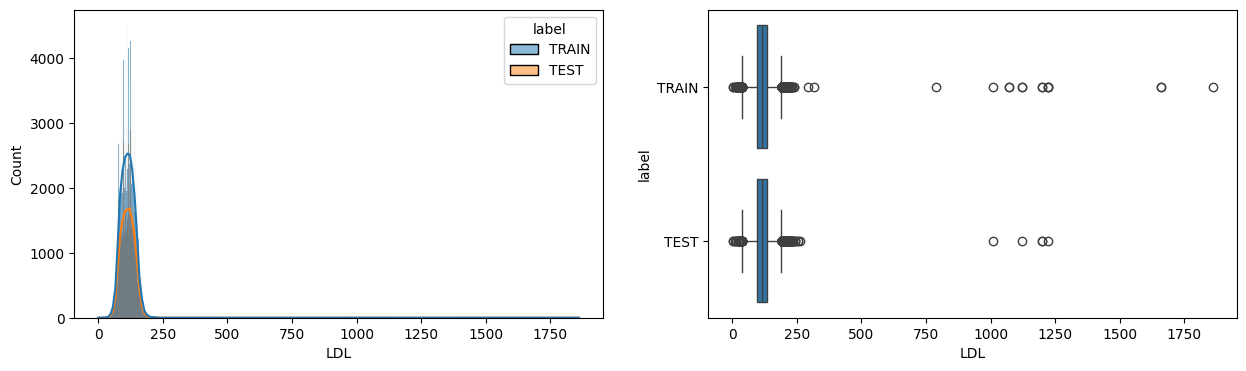

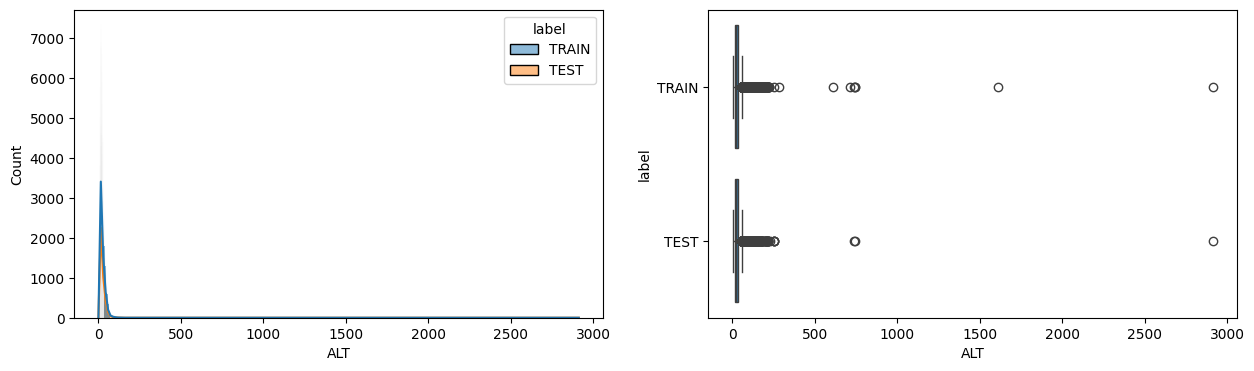

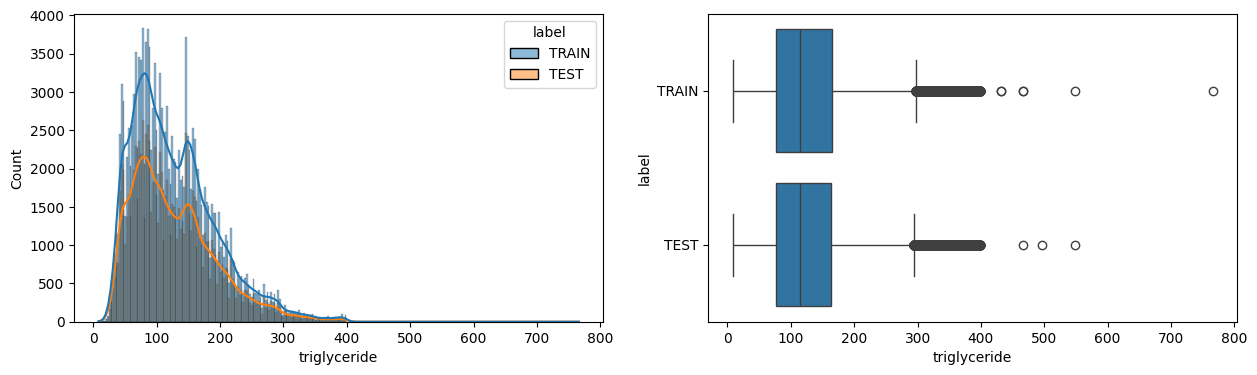

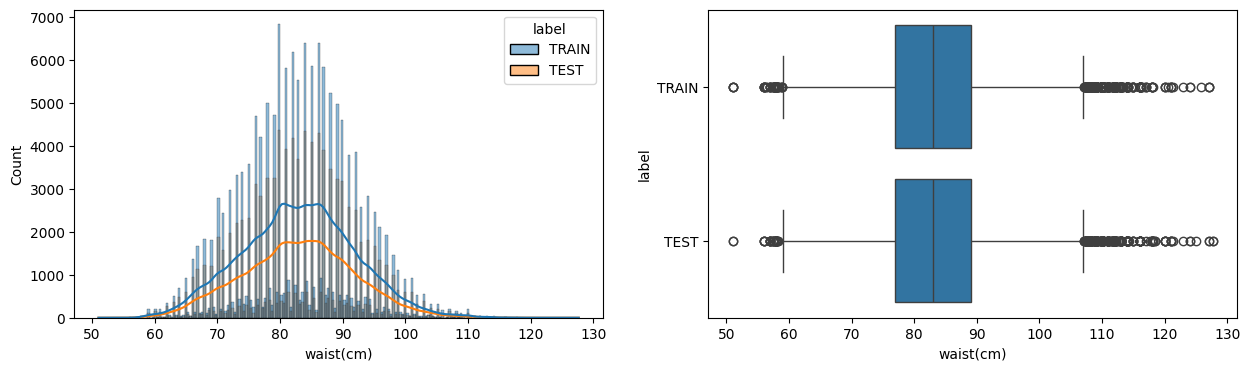

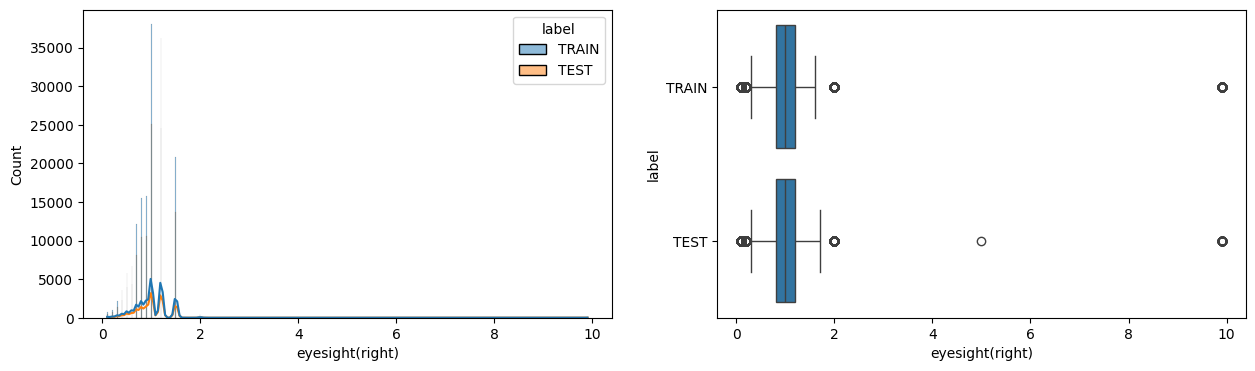

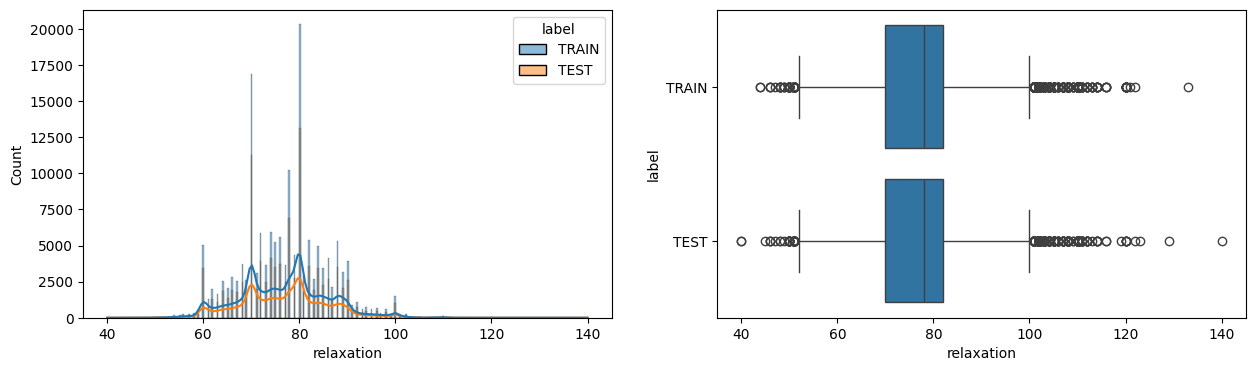

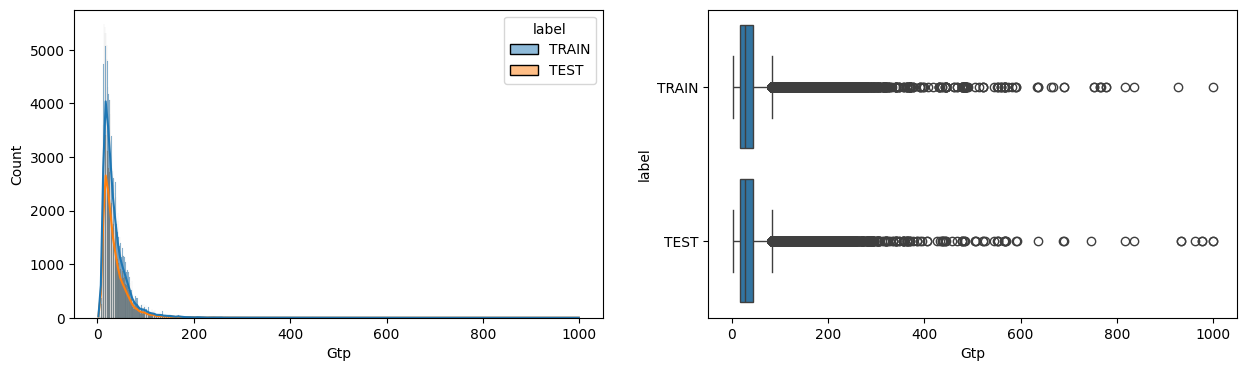

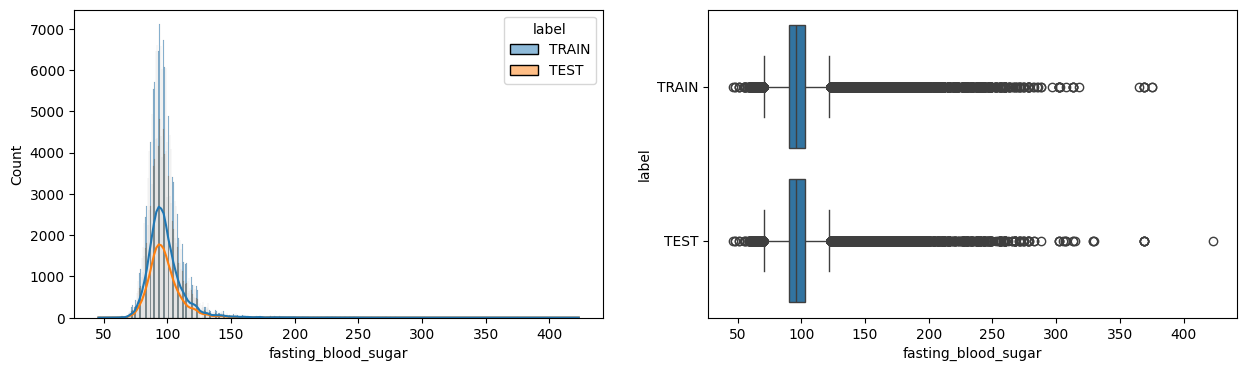

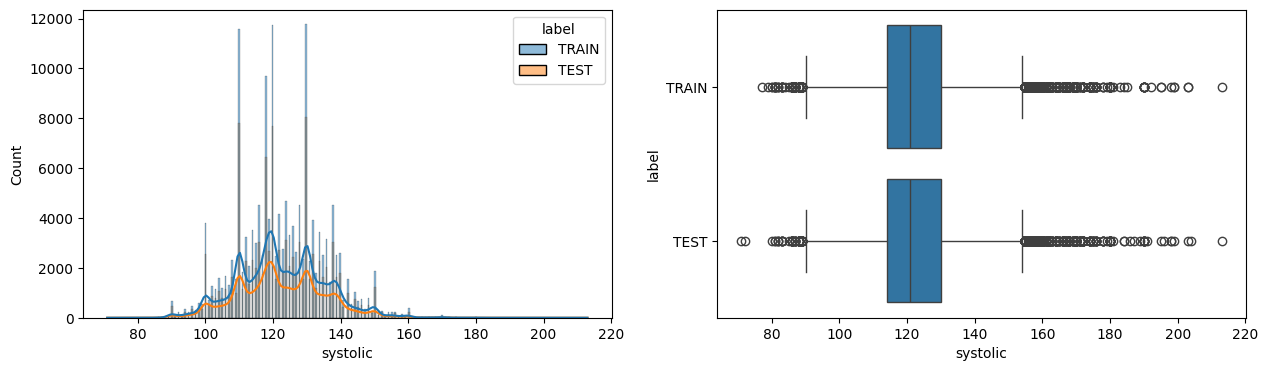

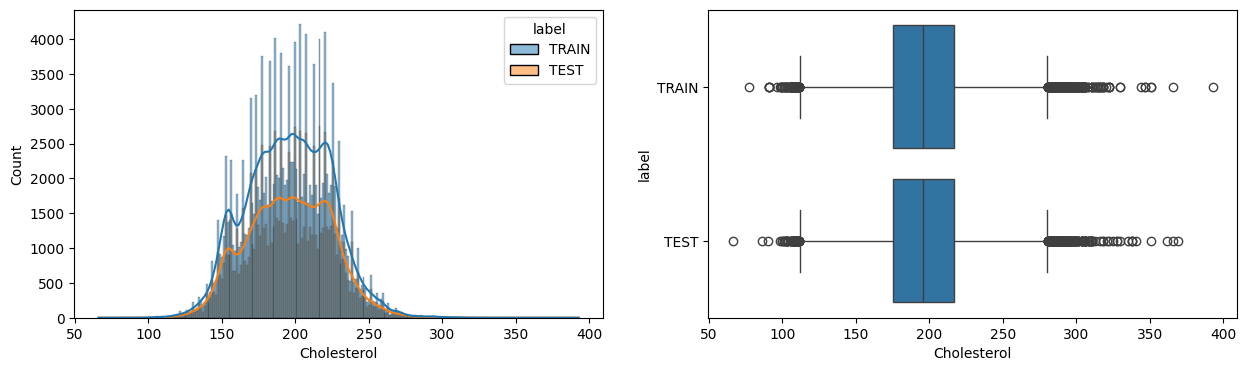

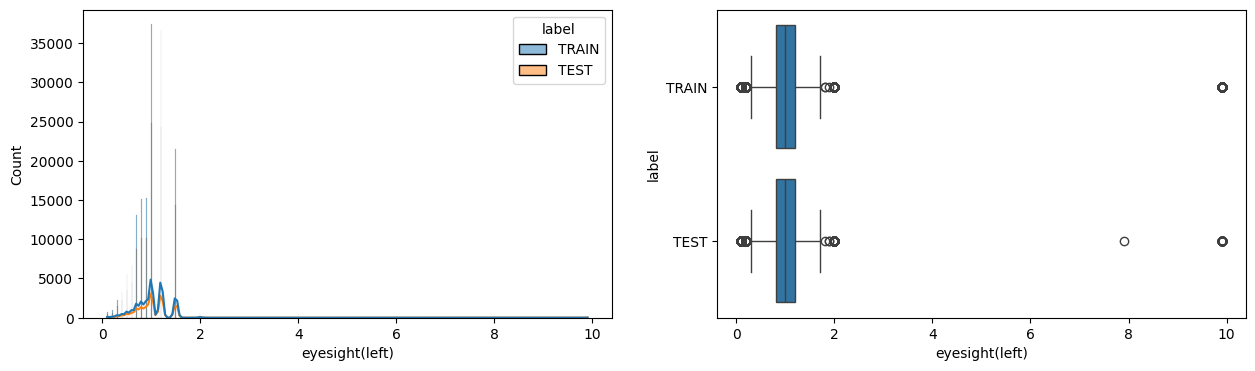

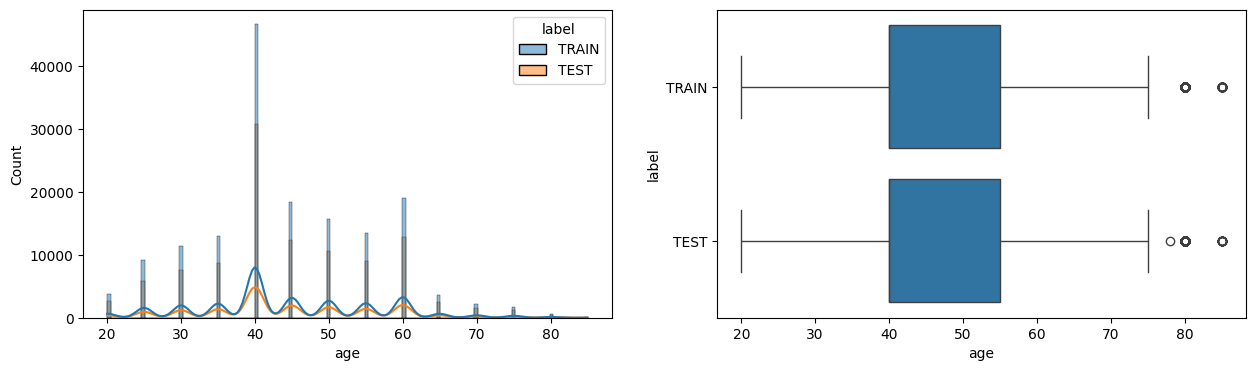

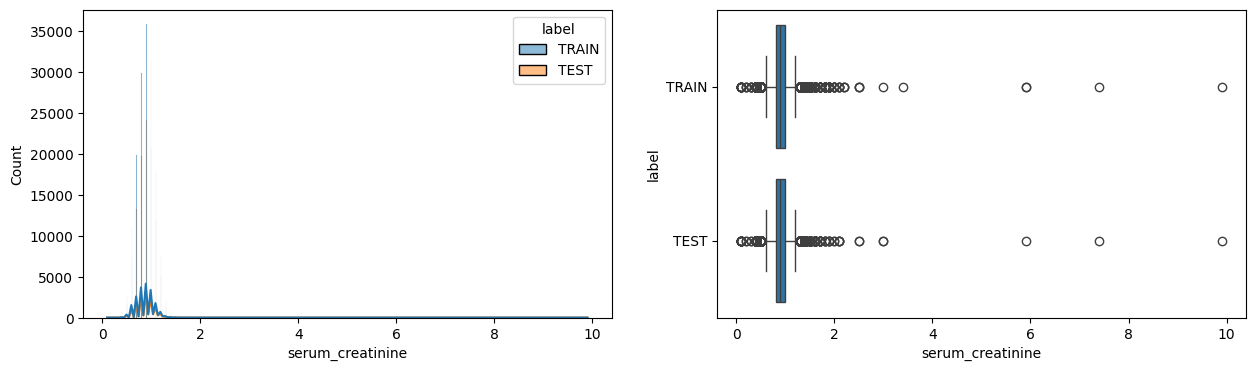

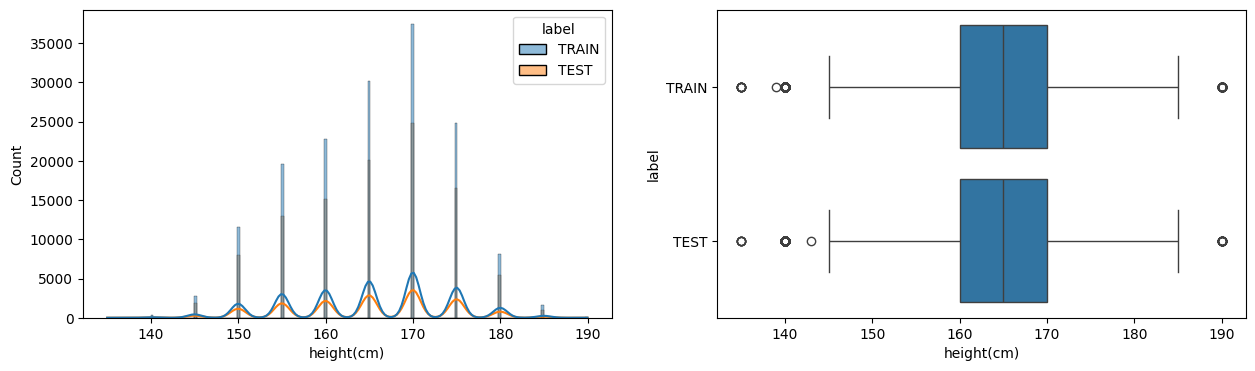

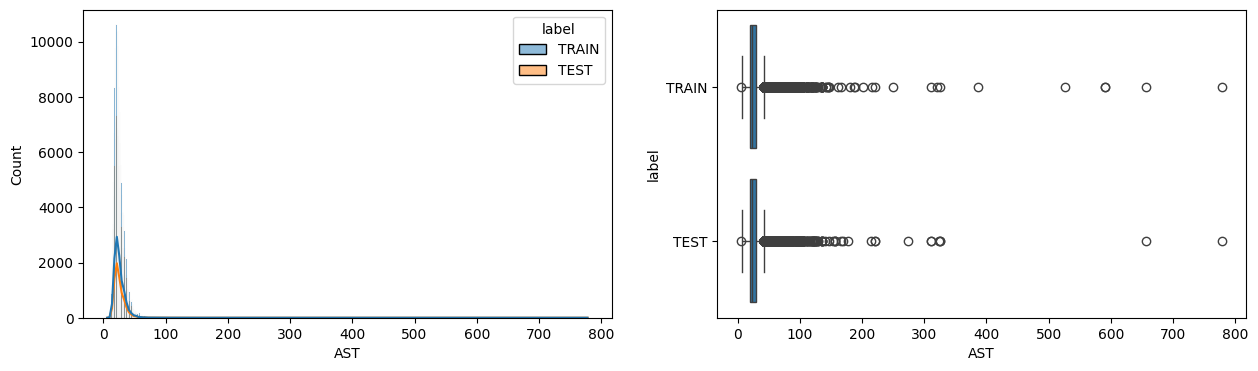

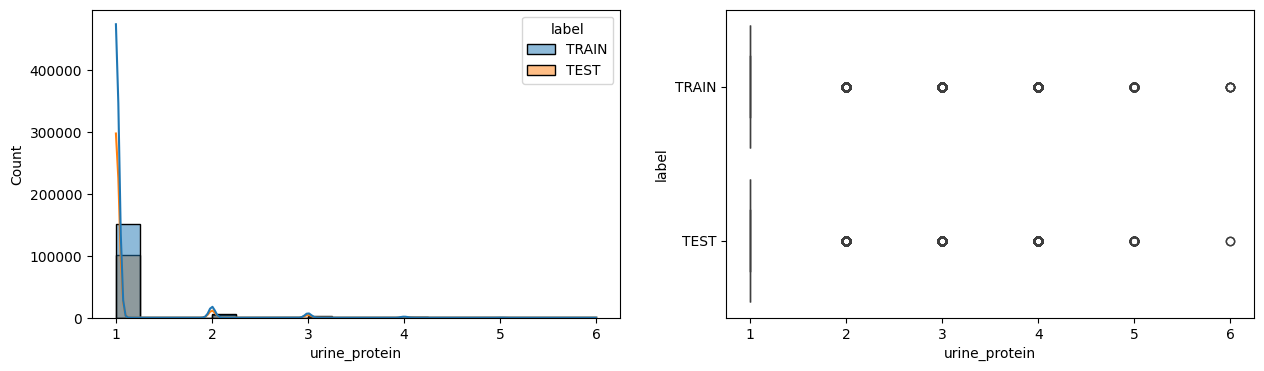

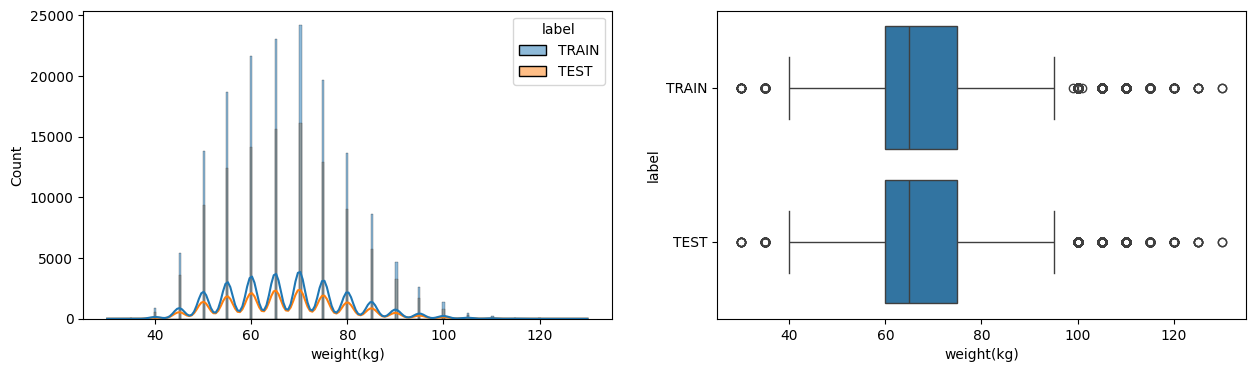

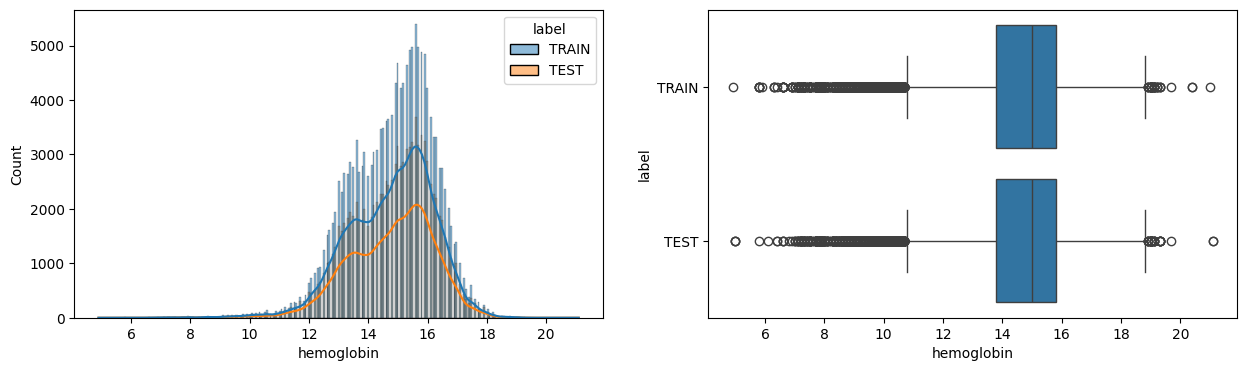

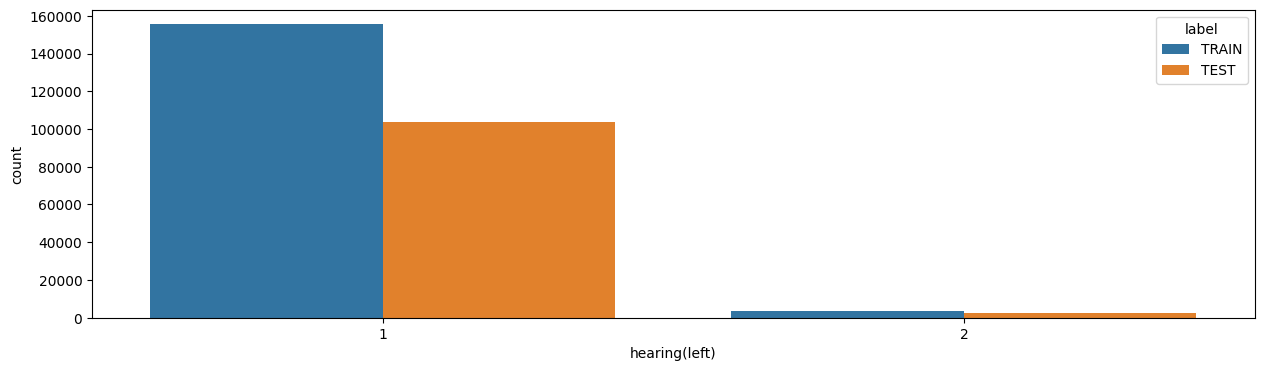

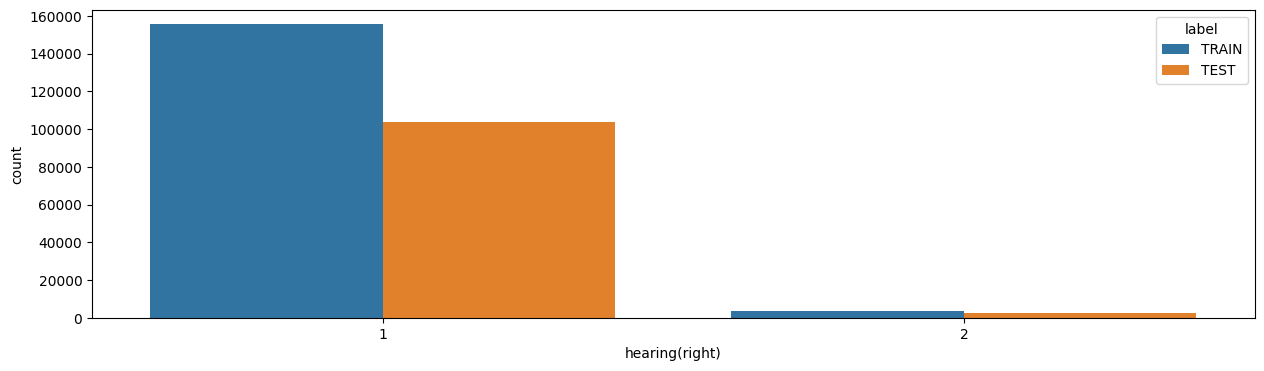

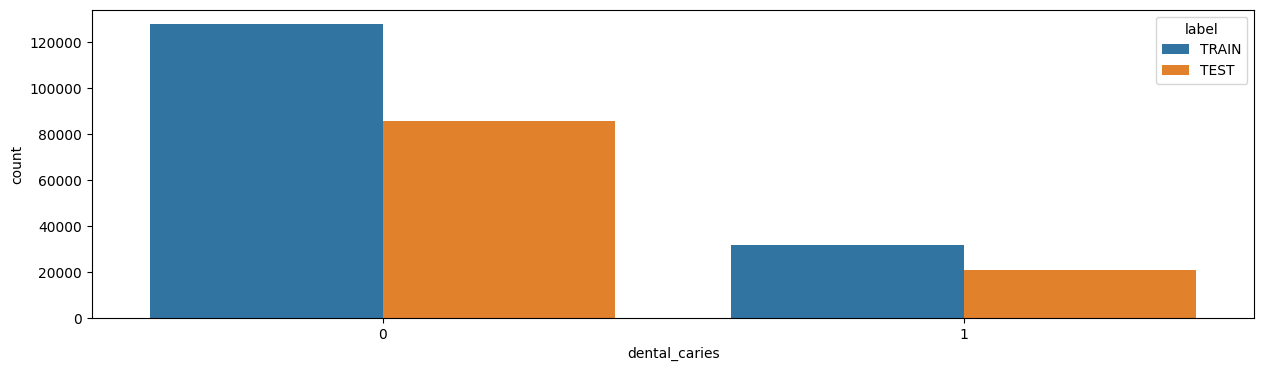

In [46]:
# plot_train_test_distribution()


In [23]:
# plot_target_variables_interaction()

In [24]:
# sns.pairplot(data=df_train,hue=target,corner=True)

In [25]:
def run_tsne():
    from sklearn.manifold import TSNE
    from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder
    from sklearn.compose import ColumnTransformer

    ct = ColumnTransformer(
        [
            ("num",StandardScaler(),num_features),
            ('cat',OneHotEncoder(),cat_features),
            ('none','drop',['id',target])
        ]
    )
  
    X = df_train.copy()
    X = ct.fit_transform(X)
    emb = TSNE(n_components=2,verbose=1,perplexity=20,early_exaggeration=25,n_jobs=-1)
    X_emb = emb.fit_transform(X)
    df_tsne = pd.DataFrame(data=X_emb,columns=['c0','c1'])
    df_tsne[target] = df_train[target]
    sns.scatterplot(data=df_tsne,x='c0',y='c1',hue=target)
    return df_tsne

In [26]:
# df_tsne = run_tsne()

In [70]:
te = TargetEncoder()

In [44]:
from xgboost import XGBClassifier
# cv = RepeatedKFold(n_splits=5,n_repeats=5,random_state=2)
# cv = KFold(n_splits=10,random_state=2,shuffle=True)
cv = StratifiedKFold(n_splits=20,random_state=2,shuffle=True)
# cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5,random_state=2)
results = cross_val_score(estimator=XGBClassifier(random_state=2),X=df_train[features],y=df_train[target],cv=cv)
print(results,np.mean(results))

[0.78538239 0.78161497 0.77508477 0.78462891 0.77659174 0.78952656
 0.77106618 0.79053121 0.77244757 0.7827452  0.78525681 0.78776843
 0.78914982 0.784001   0.79028005 0.7866382  0.78347149 0.78585782
 0.78246672 0.77970359] 0.7832106712270701


In [45]:
import tensorflow as tf

In [67]:
from sklearn.model_selection import train_test_split
X = df_train[features]
y = df_train[target]
xTrain, xTest, yTrain, yTest = train_test_split(X,y,random_state=22,stratify=y)

In [88]:
model = tf.keras.models.Sequential([
  # tf.keras.layers.Flatten(input_shape=(X.shape[1],)),
  tf.keras.layers.Input(shape=X.shape[1]),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['AUC'])

In [90]:
model.fit(xTrain, yTrain, epochs=15)

model.evaluate(xTest,  yTest, verbose=2)


Epoch 1/15
3733/3733 [==============================] - 4s 1ms/step - loss: 0.5069 - auc: 0.8215
Epoch 2/15
3733/3733 [==============================] - 4s 973us/step - loss: 0.5059 - auc: 0.8224
Epoch 3/15
3733/3733 [==============================] - 4s 978us/step - loss: 0.5044 - auc: 0.8232
Epoch 4/15
3733/3733 [==============================] - 4s 969us/step - loss: 0.5052 - auc: 0.8226
Epoch 5/15
3733/3733 [==============================] - 4s 979us/step - loss: 0.5039 - auc: 0.8233
Epoch 6/15
3733/3733 [==============================] - 4s 974us/step - loss: 0.5028 - auc: 0.8243
Epoch 7/15
3733/3733 [==============================] - 4s 978us/step - loss: 0.5028 - auc: 0.8244
Epoch 8/15
3733/3733 [==============================] - 4s 976us/step - loss: 0.5015 - auc: 0.8254
Epoch 9/15
3733/3733 [==============================] - 4s 972us/step - loss: 0.5019 - auc: 0.8249
Epoch 10/15
3733/3733 [==============================] - 4s 975us/step - loss: 0.5020 - auc: 0.8251
Epoch 11/15

[0.49030613899230957, 0.835476815700531]

In [75]:
7*3733

26131